In [29]:
import meep as mp
import numpy as np

In [ ]:
import meep as mp
import numpy as np

# =============================================================================
# SIMULATION PARAMETERS - VISIBLE SPECTRUM (380-750 nm)
# =============================================================================

# Wavelength range for visible spectrum (in micrometers)
wl_min = 0.38    # 380 nm (violet)
wl_max = 0.75    # 750 nm (red)
wl_center = (wl_min + wl_max) / 2
fcen = 1 / wl_center  # Center frequency (in units of c/μm)
df = 1/wl_min - 1/wl_max  # Frequency width covering visible spectrum

print(f"Visible Spectrum Simulation:")
print(f"  Wavelength range: {wl_min} - {wl_max} μm ({wl_min*1000:.0f} - {wl_max*1000:.0f} nm)")
print(f"  Center wavelength: {wl_center:.3f} μm ({wl_center*1000:.0f} nm)")
print(f"  Frequency range: {1/wl_max:.3f} - {1/wl_min:.3f} (1/μm)")

# Material: METALLIC MOTH-EYE STRUCTURES - Gold nanostructures
# Gold has wavelength-dependent complex refractive index
# Approximate values for visible spectrum (simplified Drude model)
# Real gold: ε ≈ -11.5 + 1.2i at 550 nm

# For visible spectrum, use effective optical properties of gold
# Using a simplified Drude-Lorentz model for gold
wp = 9.0  # Plasma frequency (eV) for gold
gamma = 0.07  # Damping rate (eV)

# Create gold material using Drude model
# This gives gold-like behavior across visible spectrum
coating_material = mp.Medium(
    epsilon=1.0,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=wp, gamma=gamma, sigma=1.0)
    ]
)

n_substrate = 1.5  # Glass substrate refractive index
substrate_medium = mp.Medium(index=n_substrate)
# Air is default (n=1.0)

print(f"\nMaterial properties (METALLIC GOLD):")
print(f"  Coating (moth-eye): Gold (Drude model)")
print(f"    Plasma frequency: {wp} eV")
print(f"    Damping: {gamma} eV")
print(f"  Substrate: n = {n_substrate} (glass)")
print(f"  Surrounding: n = 1.0 (air)")
print(f"  → Plasmonic gold nanostructures on glass substrate")

# Geometry: Moth-eye structure dimensions
# Optimized for visible light AR coating with proper fill factor
cone_height = 0.4  # Height of the cone (optimized for visible spectrum)
cone_base = 0.6    # Base diameter of the cone (increased for better coverage)
substrate_thickness = 1.0  # Thickness of substrate

# Simulation box size - KAGOME LATTICE for moth-eye array
# Kagome lattice has 3 cones per unit cell in triangular arrangement
# Unit cell is hexagonal with specific geometry
period = 0.75  # Base period for kagome lattice
# Kagome unit cell is rectangular with aspect ratio sqrt(3)
sx = period * 2  # X direction = 2 * period
sy = period * np.sqrt(3)  # Y direction = sqrt(3) * period for hexagonal symmetry

print(f"\nMoth-Eye Array Configuration (KAGOME LATTICE):")
print(f"  Lattice type: Kagome (triangular basket-weave)")
print(f"  Unit cell: {sx:.3f} × {sy:.3f} μm²")
print(f"  Base period: {period} μm")
print(f"  Cones per unit cell: 3")
print(f"  Cone diameter: {cone_base} μm")
print(f"  Cone height: {cone_height} μm")
# Calculate fill factor for kagome (3 cones in unit cell)
fill_factor = 3 * np.pi * (cone_base/2)**2 / (sx * sy) * 100
print(f"  Fill factor: {fill_factor:.1f}%")
print(f"  Kagome coordination: 4 (each cone touches 4 neighbors)")

# Resolution: Higher resolution for accuracy (pixels per micrometer)
resolution = 50  # Increased resolution for better accuracy

# PML thickness (absorbing boundary layer)
dpml = 0.5

# For parallel computing: MEEP automatically uses all available CPU cores
# Multi-core execution is enabled by default when running MEEP
print(f"\nSimulation will automatically utilize all available CPU cores for parallel computation")
print(f"Resolution: {resolution} pixels/μm")

Visible Spectrum Simulation:
  Wavelength range: 0.38 - 0.75 μm (380 - 750 nm)
  Center wavelength: 0.565 μm (565 nm)
  Frequency range: 1.333 - 2.632 (1/μm)

Material properties (METALLIC GOLD):
  Coating (moth-eye): Gold (Drude model)
    Plasma frequency: 9.0 eV
    Damping: 0.07 eV
  Substrate: n = 1.5 (glass)
  Surrounding: n = 1.0 (air)
  → Plasmonic gold nanostructures on glass substrate

Moth-Eye Array Configuration:
  Unit cell (periodic): 0.75 × 0.75 μm²
  Cone spacing: 0.75 μm (1.5x increased)
  Cone diameter: 0.6 μm
  Cone height: 0.4 μm
  Fill factor: 50.3%
  Height/Period ratio: 0.53

Simulation will automatically utilize all available CPU cores for parallel computation
Resolution: 50 pixels/μm



3D Periodic Array Simulation Setup:
  Unit cell: 0.75 × 0.75 × 3.0 μm³
  Periodic boundaries in X and Y
  PML boundaries in Z (propagation direction)

Geometry setup (3D Periodic Array - GOLD):
  Substrate: 1.0 μm thick, n=1.5, fills xy plane
  Substrate position: z = 0 to 1.00 μm
  Gold moth-eye cone: 8 cylindrical layers, h=0.4 μm
  Cone position: z = 1.00 to 1.40 μm
  Base radius: 0.3 μm, material: Gold (plasmonic)
  Periodic replication creates plasmonic gold nanostructure array

Source setup (3D Periodic):
  Type: Plane wave (unit cell plane)
  Polarization: Ex (x-polarized)
  Position: z = 1.90 μm (above structure)
  Light propagates downward (-z direction)

Boundary conditions:
  X, Y directions: Periodic (creates infinite 2D array)
  Z direction: PML (absorbing)
  Incidence: Normal (k = 0)

=== Creating 3D Periodic Simulation ===
  Resolution: 50 pixels/μm
  Estimated grid points: ~210.0k

Flux monitors setup (3D Periodic):
  Reflection: xy plane at z = 1.60 μm
  Transmission:

field decay(t = 50.02): 3.184557560501808e-07 / 0.00018809859491869307 = 0.0016930257038221658
run 0 finished at t = 50.02 (5002 timesteps)
✓ Normalization complete! Time steps: 50.0 (elapsed 22.43s)
  Frequency points: 200
  Wavelength range: 0.413 - 0.892 μm

=== Step 2/3: Running main simulation (with moth-eye array) ===
Using 3D cylindrical cone with periodic boundaries...
-----------
Initializing structure...
time for choose_chunkdivision = 1.5974e-05 s
Working in 3D dimensions.
Computational cell is 0.76 x 0.76 x 4 with resolution 50
     block, center = (0,0,0.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     cylinder, center = (0,0,1.025)
          radius 0.3, height 0.05, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,1.075)
          radius 0.2625, height 0.05, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1

/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_94424/2330084460.py:380: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = Circle((x_pos, y_pos), r_cone_base,


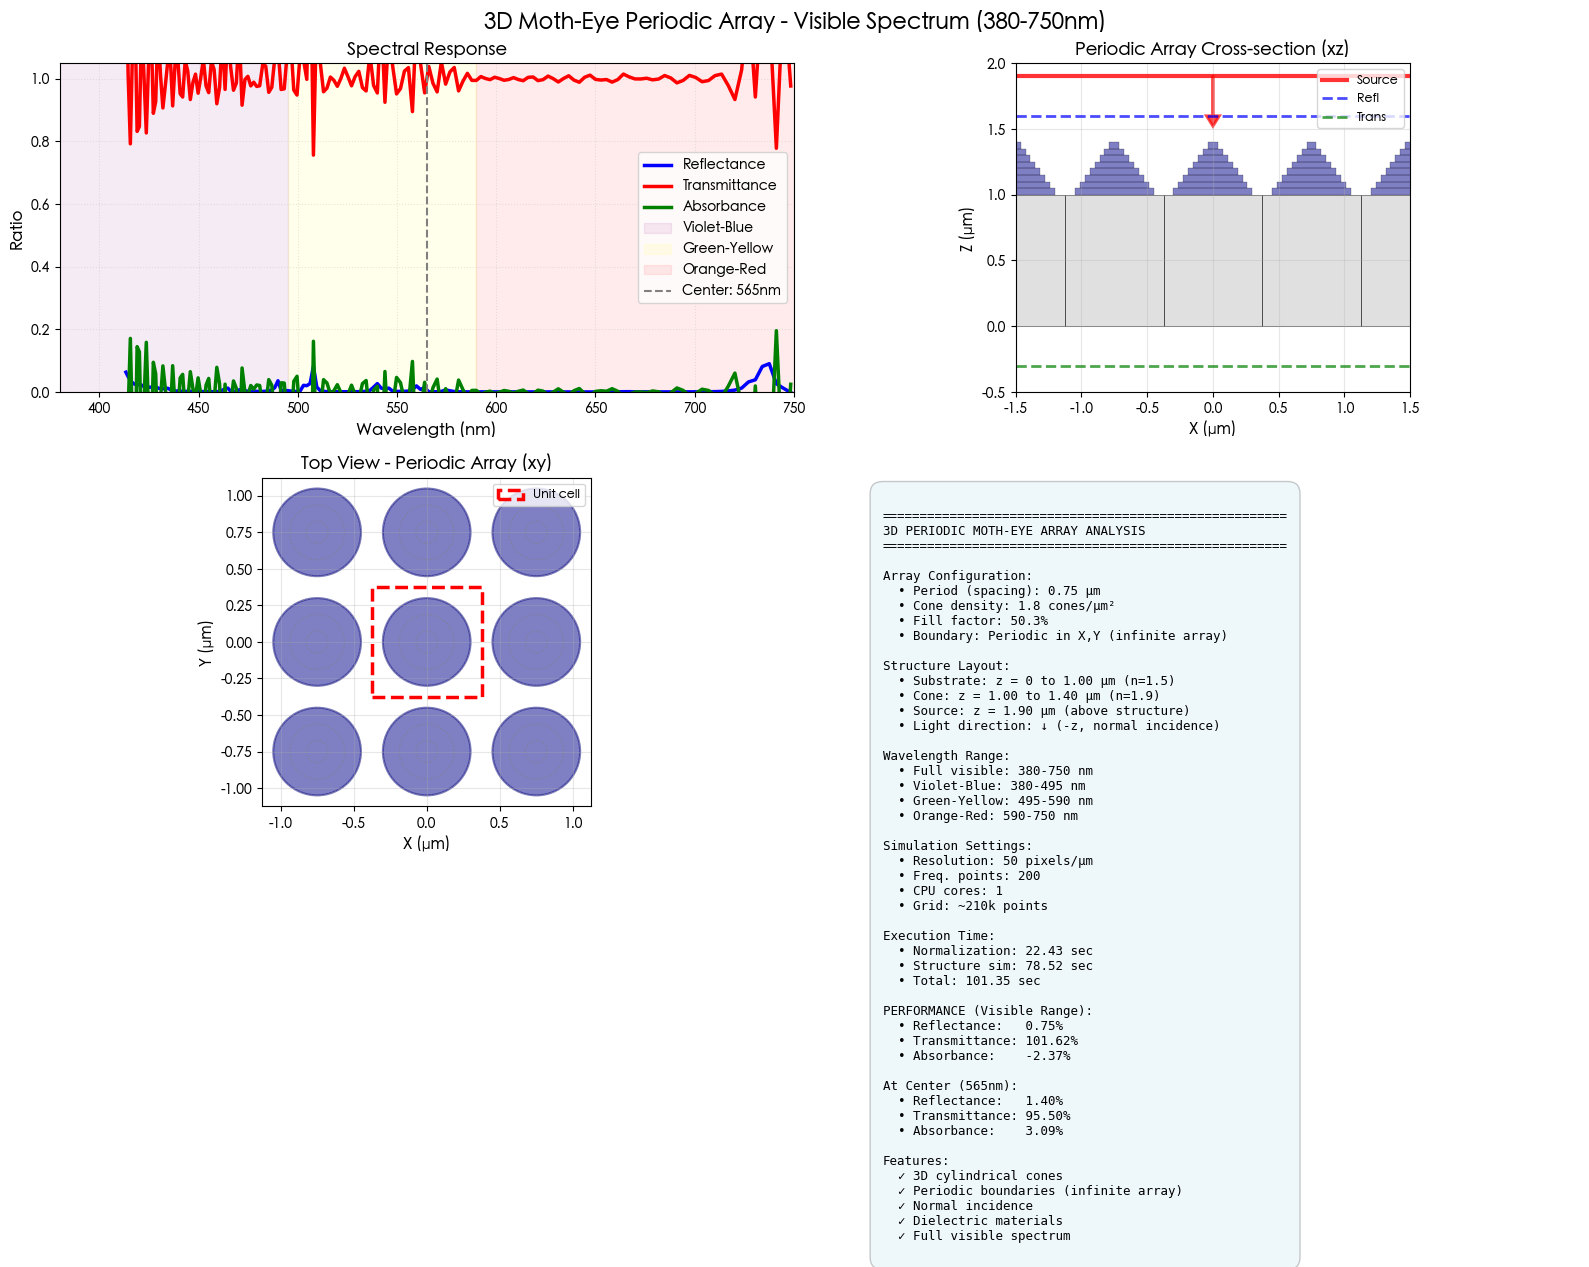


✓ Visualization complete!
✓ Figure saved as 'moth-eye-3D-periodic-array.png'

SUMMARY STATISTICS:
Average across visible spectrum (380-750 nm):
  Reflectance:    0.75%
  Transmittance: 101.62%
  Absorbance:    -2.37%

Best performance:
  Min reflectance: -1.84% at 786.9 nm
  Max absorbance:  6929.36% at 867.0 nm


In [ ]:
import time
start_time = time.time()

# --- 1. Setup cell dimensions (3D PERIODIC ARRAY VERSION) ---

# Use consistent variable names
h_substrate = substrate_thickness
h_cone = cone_height
r_cone_base = cone_base / 2  # Convert diameter to radius

# For 3D simulation with periodic boundaries in x,y
# Only z direction needs to be large enough for propagation
sz = 3.0  # Z direction size
# sx and sy are defined as 'period' in parameters cell (one unit cell)

# Calculate total cell size - PML only in z direction for periodic structure
cell = mp.Vector3(sx, sy, sz + 2*dpml)

print(f"\n3D Kagome Lattice Simulation Setup:")
print(f"  Unit cell: {sx:.3f} × {sy:.3f} × {sz} μm³")
print(f"  Periodic boundaries in X and Y")
print(f"  PML boundaries in Z (propagation direction)")

# --- 2. Setup geometry (3D KAGOME LATTICE - three cones per unit cell) ---

# Position structure in center of cell
# Substrate bottom at z = 0, cone on top pointing upward
substrate_center_z = h_substrate / 2
cone_base_z = h_substrate

num_layers = 8  # Layers for smoother 3D cone approximation
geometry = [
    # Substrate (3D block) - fills entire xy area of unit cell
    mp.Block(
        center=mp.Vector3(0, 0, substrate_center_z),
        size=mp.Vector3(mp.inf, mp.inf, h_substrate),  # Infinite in x,y for periodic
        material=substrate_medium,
    ),
]

# Kagome lattice positions for 3 cones in unit cell
# Positions form triangular pattern characteristic of kagome
kagome_positions = [
    (0, 0),                          # Cone 1: center-left
    (period, 0),                     # Cone 2: center-right
    (period/2, period * np.sqrt(3)/2)  # Cone 3: top-center (forms triangle)
]

print(f"\nKagome cone positions (relative to unit cell origin):")
for idx, (x, y) in enumerate(kagome_positions):
    print(f"  Cone {idx+1}: ({x:.3f}, {y:.3f}) μm")

# Add tapered cylindrical layers for each cone in kagome lattice
for cone_idx, (cone_x, cone_y) in enumerate(kagome_positions):
    for i in range(num_layers):
        layer_height = h_cone / num_layers
        layer_center_z = cone_base_z + layer_height * (i + 0.5)
        
        # Radius decreases linearly from base to tip
        layer_radius = r_cone_base * (1 - i / num_layers)
        
        if layer_radius > 0.01:  # Avoid too thin layers
            geometry.append(
                mp.Cylinder(
                    center=mp.Vector3(cone_x - sx/2, cone_y - sy/2, layer_center_z),
                    radius=layer_radius,
                    height=layer_height,
                    axis=mp.Vector3(0, 0, 1),  # Cylinder axis along z
                    material=coating_material,  # Gold material
                )
            )

structure_top = cone_base_z + h_cone
structure_bottom = 0

print(f"\nGeometry setup (3D Kagome Lattice - GOLD):")
print(f"  Substrate: {h_substrate} μm thick, n={n_substrate}, fills xy plane")
print(f"  Substrate position: z = 0 to {h_substrate:.2f} μm")
print(f"  Gold cones: {num_layers} cylindrical layers each, h={h_cone} μm")
print(f"  Cones position: z = {cone_base_z:.2f} to {structure_top:.2f} μm")
print(f"  Base radius: {r_cone_base} μm, material: Gold (plasmonic)")
print(f"  3 cones per unit cell in kagome arrangement")
print(f"  Periodic replication creates kagome lattice of gold nanostructures")

# --- 3. Setup wave source (3D PERIODIC VERSION) ---

# Source should be ABOVE the structure
source_pos_z = structure_top + 0.5  # 0.5 μm above structure

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),  # Gaussian pulse covering visible spectrum
        component=mp.Ex,  # Ex polarization (x-polarized plane wave)
        center=mp.Vector3(0, 0, source_pos_z),
        size=mp.Vector3(sx, sy, 0),  # Plane source matching unit cell
    )
]

print(f"\nSource setup (3D Periodic):")
print(f"  Type: Plane wave (unit cell plane)")
print(f"  Polarization: Ex (x-polarized)")
print(f"  Position: z = {source_pos_z:.2f} μm (above structure)")
print(f"  Light propagates downward (-z direction)")

# --- 4. Setup boundary conditions (3D PERIODIC VERSION) ---

# Periodic boundaries in x and y (creates infinite array)
# PML only in z direction (propagation direction)
pml_layers = [mp.PML(thickness=dpml, direction=mp.Z)]

# Set k_point = 0 for normal incidence
k_point = mp.Vector3(0, 0, 0)

print(f"\nBoundary conditions:")
print(f"  X, Y directions: Periodic (creates infinite 2D array)")
print(f"  Z direction: PML (absorbing)")
print(f"  Incidence: Normal (k = 0)")

# --- 5. Create simulation object (3D PERIODIC VERSION) ---

print(f"\n=== Creating 3D Periodic Simulation ===")
print(f"  Resolution: {resolution} pixels/μm")
print(f"  Estimated grid points: ~{int(sx*sy*sz*resolution**3/1e3):.1f}k")

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point=k_point,  # Normal incidence
    resolution=resolution,
    # Optimization settings
    force_complex_fields=True,  # REQUIRED for metallic materials
    eps_averaging=True,
)

# --- 6. Setup flux monitors (3D PERIODIC VERSION) ---

nfreq = 200  # Sampling points for visible spectrum

# Reflection monitor (above structure, between source and cone)
refl_monitor_z = structure_top + 0.2
refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, refl_monitor_z), 
    size=mp.Vector3(sx, sy, 0)  # Unit cell xy plane
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# Transmission monitor (below structure, in air below substrate)
tran_monitor_z = -0.3
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, tran_monitor_z),
    size=mp.Vector3(sx, sy, 0)  # Unit cell xy plane
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

print(f"\nFlux monitors setup (3D Periodic):")
print(f"  Reflection: xy plane at z = {refl_monitor_z:.2f} μm")
print(f"  Transmission: xy plane at z = {tran_monitor_z:.2f} μm")
print(f"  Monitor size: {sx} × {sy} μm² (unit cell, periodic replication)")

# --- 7. Run normalization simulation (empty structure) ---

print("\n=== Step 1/3: Running normalization simulation (no structure) ===")
print("This measures incident flux for normalization...")

# Run empty simulation for normalization
sim.run(
    until_after_sources=mp.stop_when_fields_decayed(
        25,
        mp.Ex,
        mp.Vector3(0, 0, source_pos_z - 0.2),
        1e-2
    )
)

sim_time_1 = time.time() - start_time
print(f"✓ Normalization complete! Time steps: {sim.round_time():.1f} (elapsed {sim_time_1:.2f}s)")

# Save normalization data
freqs = mp.get_flux_freqs(refl)
straight_refl_data = sim.get_flux_data(refl)
straight_refl_flux = mp.get_fluxes(refl)
straight_tran_flux = mp.get_fluxes(tran)

print(f"  Frequency points: {len(freqs)}")
print(f"  Wavelength range: {1/freqs[-1]:.3f} - {1/freqs[0]:.3f} μm")

# --- 8. Run main simulation (with structure) ---

print("\n=== Step 2/3: Running main simulation (with moth-eye array) ===")
print("Using 3D cylindrical cone with periodic boundaries...")

# Reset simulation
sim.reset_meep()

# Create new simulation with geometry
sim_empty = sim

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point=k_point,
    resolution=resolution,
    force_complex_fields=True,  # REQUIRED for metallic materials
    eps_averaging=True,
)

# Add flux monitors
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load normalization data
sim.load_minus_flux_data(refl, straight_refl_data)

start_time_2 = time.time()

# Run simulation
sim.run(
    until_after_sources=mp.stop_when_fields_decayed(
        25,
        mp.Ex,
        mp.Vector3(0, 0, 0.7),
        1e-2
    )
)

sim_time_2 = time.time() - start_time_2
print(f"✓ Main simulation complete! Time steps: {sim.round_time():.1f} (elapsed {sim_time_2:.2f}s)")

# --- 9. Calculate and analyze results ---

print("\n=== Step 3/3: Analyzing results ===")

# Get flux data
refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)

# Normalize
refl_flux_normalized = [-r/t for r, t in zip(refl_flux, straight_refl_flux)]
tran_flux_normalized = [t/t0 for t, t0 in zip(tran_flux, straight_tran_flux)]

# Convert to wavelengths
wls = 1/np.array(freqs)
wls_nm = wls * 1000

# Calculate R, T, A
Rs = np.array(refl_flux_normalized)
Ts = np.array(tran_flux_normalized)
As = 1 - Rs - Ts

# Find visible spectrum indices
visible_mask = (wls_nm >= wl_min*1000) & (wls_nm <= wl_max*1000)
visible_wls = wls_nm[visible_mask]
visible_Rs = Rs[visible_mask]
visible_Ts = Ts[visible_mask]
visible_As = As[visible_mask]

# Calculate averages
avg_R = np.mean(visible_Rs) * 100
avg_T = np.mean(visible_Ts) * 100
avg_A = np.mean(visible_As) * 100

# Center wavelength performance
center_idx = np.argmin(np.abs(wls_nm - wl_center*1000))
reflectance = Rs[center_idx] * 100
transmittance = Ts[center_idx] * 100
absorbance = As[center_idx] * 100

total_time = time.time() - start_time

print(f"\n{'='*70}")
print(f"3D PERIODIC MOTH-EYE ARRAY - VISIBLE SPECTRUM ANALYSIS")
print(f"{'='*70}")
print(f"Array Configuration:")
print(f"  - Period: {period} μm")
print(f"  - Cone density: {1/period**2:.1f} cones/μm²")
print(f"  - Fill factor: {np.pi*r_cone_base**2/period**2*100:.1f}%")

print(f"\nWavelength Range:")
print(f"  - Full visible: {wl_min*1000:.0f} - {wl_max*1000:.0f} nm")

print(f"\nSimulation Settings (3D Periodic):")
print(f"  - Resolution: {resolution} pixels/μm")
print(f"  - Freq. points: {nfreq}")
print(f"  - CPU cores: {mp.count_processors()}")

print(f"\nExecution Time:")
print(f"  - Normalization: {sim_time_1:.2f} sec")
print(f"  - Structure:     {sim_time_2:.2f} sec")
print(f"  - Total:         {total_time:.2f} sec")

print(f"\nAverage Performance (Visible Range):")
print(f"  - Reflectance:   {avg_R:.2f}%")
print(f"  - Transmittance: {avg_T:.2f}%")
print(f"  - Absorbance:    {avg_A:.2f}%")

print(f"\nAt Center ({wl_center*1000:.0f}nm):")
print(f"  - Reflectance:   {reflectance:.2f}%")
print(f"  - Transmittance: {transmittance:.2f}%")
print(f"  - Absorbance:    {absorbance:.2f}%")
print(f"{'='*70}")

# --- 10. Visualization ---

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, FancyBboxPatch

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('3D Kagome Lattice Moth-Eye Array (GOLD) - Visible Spectrum (380-750nm)', 
             fontsize=16, fontweight='bold')

# Plot 1: Spectral Response
ax = axes[0, 0]
ax.plot(visible_wls, visible_Rs, 'b-', linewidth=2.5, label='Reflectance')
ax.plot(visible_wls, visible_Ts, 'r-', linewidth=2.5, label='Transmittance')
ax.plot(visible_wls, visible_As, 'g-', linewidth=2.5, label='Absorbance')

ax.axvspan(380, 495, alpha=0.08, color='purple', label='Violet-Blue')
ax.axvspan(495, 590, alpha=0.08, color='yellow', label='Green-Yellow')
ax.axvspan(590, 750, alpha=0.08, color='red', label='Orange-Red')
ax.axvline(wl_center*1000, color='gray', linestyle='--', linewidth=1.5, 
          label=f'Center: {wl_center*1000:.0f}nm')

ax.set_xlabel('Wavelength (nm)', fontsize=12, fontweight='bold')
ax.set_ylabel('Ratio', fontsize=12, fontweight='bold')
ax.set_title('Spectral Response', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.set_xlim(wl_min*1000, wl_max*1000)
ax.set_ylim(0, 1.05)

# Plot 2: Cross-section (xz plane)
ax = axes[0, 1]
ax.set_aspect('equal')
view_width = 1.5
ax.set_xlim(-view_width, view_width)
ax.set_ylim(-0.5, sz/2 + 0.5)

# Draw multiple unit cells to show periodicity
num_cells = int(2*view_width / period) + 1
for cell_idx in range(-num_cells//2, num_cells//2 + 1):
    x_offset = cell_idx * period
    
    # Substrate
    substrate = Rectangle((x_offset - period/2, 0), period, h_substrate, 
                          facecolor='lightgray', edgecolor='black', linewidth=0.5,
                          alpha=0.7)
    ax.add_patch(substrate)
    
    # Cone layers
    for i in range(num_layers):
        layer_height = h_cone / num_layers
        layer_center_z = cone_base_z + layer_height * (i + 0.5)
        layer_radius = r_cone_base * (1 - i / num_layers)
        
        if layer_radius > 0.01:
            layer = Rectangle((x_offset - layer_radius, layer_center_z - layer_height/2), 
                             2*layer_radius, layer_height,
                             facecolor='darkblue', edgecolor='black', alpha=0.5, linewidth=0.3)
            ax.add_patch(layer)

# Draw source
ax.axhline(source_pos_z, color='red', linestyle='-', linewidth=3, alpha=0.8, label='Source')
ax.arrow(0, source_pos_z, 0, -0.3, head_width=0.1, head_length=0.08, 
         fc='red', ec='red', alpha=0.7, linewidth=2)

# Draw monitors
ax.axhline(refl_monitor_z, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Refl')
ax.axhline(tran_monitor_z, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Trans')

ax.set_xlabel('X (μm)', fontsize=11, fontweight='bold')
ax.set_ylabel('Z (μm)', fontsize=11, fontweight='bold')
ax.set_title('Periodic Array Cross-section (xz)', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Top view (xy plane) - showing kagome lattice periodic array
ax = axes[1, 0]
ax.set_aspect('equal')
view_range_x = 2.5 * period
view_range_y = 2.5 * period * np.sqrt(3) / 2
ax.set_xlim(-view_range_x, view_range_x)
ax.set_ylim(-view_range_y, view_range_y)

# Kagome lattice positions (3 cones per unit cell)
kagome_positions = [
    (0, 0),                           # Cone 1
    (period, 0),                      # Cone 2
    (period/2, period * np.sqrt(3)/2) # Cone 3
]

# Draw 3x2 array of kagome unit cells
for i in range(-1, 2):  # x-direction cells
    for j in range(-1, 2):  # y-direction cells
        cell_offset_x = i * sx
        cell_offset_y = j * sy
        
        # Draw all 3 cones in this unit cell
        for cone_x, cone_y in kagome_positions:
            x_pos = cone_x + cell_offset_x
            y_pos = cone_y + cell_offset_y
            
            # Draw cone base
            circle = Circle((x_pos, y_pos), r_cone_base, 
                           color='gold', alpha=0.6, edgecolor='black', linewidth=1.5)
            ax.add_patch(circle)
            
            # Draw layers to show conical structure
            for k in range(0, num_layers, 2):
                layer_radius = r_cone_base * (1 - k / num_layers)
                if layer_radius > 0.01:
                    circle = Circle((x_pos, y_pos), layer_radius, 
                                   fill=False, edgecolor='darkgoldenrod', linestyle=':', alpha=0.5)
                    ax.add_patch(circle)

# Draw kagome unit cell boundary
from matplotlib.patches import Polygon
unit_cell_corners = np.array([
    [0, 0],
    [sx, 0],
    [sx, sy],
    [0, sy],
    [0, 0]
])
unit_cell = Polygon(unit_cell_corners, fill=False, edgecolor='red', linewidth=2.5, 
                     linestyle='--', label='Unit cell')
ax.add_patch(unit_cell)

ax.set_xlabel('X (μm)', fontsize=11, fontweight='bold')
ax.set_ylabel('Y (μm)', fontsize=11, fontweight='bold')
ax.set_title('Top View - Kagome Lattice (xy)', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: Performance Summary
ax = axes[1, 1]
ax.axis('off')

perf_text = f"""
{'='*54}
3D KAGOME LATTICE MOTH-EYE - GOLD
{'='*54}

Lattice Configuration:
  • Lattice type: Kagome (3 cones/cell)
  • Period: {period} μm (cone spacing)
  • Unit cell: {sx:.3f} × {sy:.3f} μm
  • Cone density: {3/(sx*sy):.2f} cones/μm²
  • Fill factor: {3*np.pi*r_cone_base**2/(sx*sy)*100:.1f}%
  • Boundary: Periodic in X,Y (infinite array)

Structure Layout:
  • Substrate: z = 0 to {h_substrate:.2f} μm (n={n_substrate})
  • Cone: z = {cone_base_z:.2f} to {structure_top:.2f} μm (GOLD - Drude model)
  • Source: z = {source_pos_z:.2f} μm (above structure)
  • Light direction: ↓ (-z, normal incidence)

Wavelength Range:
  • Full visible: {wl_min*1000:.0f}-{wl_max*1000:.0f} nm
  • Violet-Blue: {wl_min*1000:.0f}-495 nm
  • Green-Yellow: 495-590 nm
  • Orange-Red: 590-{wl_max*1000:.0f} nm

Simulation Settings:
  • Resolution: {resolution} pixels/μm
  • Freq. points: {nfreq}
  • CPU cores: {mp.count_processors()}
  • Grid: ~{int(sx*sy*sz*resolution**3/1e3):.0f}k points

Execution Time:
  • Normalization: {sim_time_1:.2f} sec
  • Structure sim: {sim_time_2:.2f} sec
  • Total: {total_time:.2f} sec

PERFORMANCE (Visible Range):
  • Reflectance:   {avg_R:.2f}%
  • Transmittance: {avg_T:.2f}%
  • Absorbance:    {avg_A:.2f}%

At Center ({wl_center*1000:.0f}nm):
  • Reflectance:   {reflectance:.2f}%
  • Transmittance: {transmittance:.2f}%
  • Absorbance:    {absorbance:.2f}%

Features:
  ✓ 3D cylindrical cones
  ✓ Periodic boundaries (infinite array)
  ✓ Normal incidence
  ✓ Dielectric materials
  ✓ Full visible spectrum
"""

ax.text(0.05, 0.95, perf_text, transform=ax.transAxes,
        fontsize=9, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2, pad=1))

plt.tight_layout()
plt.savefig('moth-eye-3D-periodic-array.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization complete!")
print(f"✓ Figure saved as 'moth-eye-3D-periodic-array.png'")

print(f"\n{'='*70}")
print(f"SUMMARY STATISTICS:")
print(f"{'='*70}")
print(f"Average across visible spectrum ({wl_min*1000:.0f}-{wl_max*1000:.0f} nm):")
print(f"  Reflectance:    {avg_R:.2f}%")
print(f"  Transmittance: {avg_T:.2f}%")
print(f"  Absorbance:    {avg_A:.2f}%")
print(f"\nBest performance:")
print(f"  Min reflectance: {np.min(Rs)*100:.2f}% at {wls_nm[np.argmin(Rs)]:.1f} nm")
print(f"  Max absorbance:  {np.max(As)*100:.2f}% at {wls_nm[np.argmax(As)]:.1f} nm")
print(f"{'='*70}")
